For our objective, it's particularly important to focus not just on overall accuracy but also on the model's ability to correctly identify the high-risk patients (Class 1). This is why metrics like recall, precision, ROC AUC, and F1-score for the mortality class are essential.

Model Interpretation: For some of the more elementary models we performed feature importance analysis,to provide us insights into which factors are most predictive of near-term mortality, helping clinicians understand key risk factors.

Use in Clinical Settings: Such models, if deployed in clinical settings, can assist healthcare professionals in making informed decisions, but they should be used as a supplement to, not a replacement for, clinical judgment and expertise.


Load the features and labels for the specific task (in-hospital mortality at 48 hours). This will involve importing necessary packages and reading the data files.

In [2]:
import sparse
import json
import pandas as pd


s = sparse.load_npz('Features/s.npz').todense()
X = sparse.load_npz('Features/X.npz').todense()

s_feature_names = json.load(open('Features/s.feature_names.json', 'r'))
X_feature_names = json.load(open('Features/X.feature_names.json', 'r'))

df_pop = pd.read_csv('Population/mortality_48h.csv')


Why I decided to combine the time-invariant and time-dependent features for this file

Holistic View of Data: Combining both time-invariant and time-dependent features provides a more comprehensive view of each patient's record. Time-invariant data often includes critical baseline information, while time-dependent data captures dynamic changes. Using both together allows the model to make more informed predictions.

Model Limitations: Most traditional machine learning models, including Random Forest, expect input data in a tabular format (2D). They are not designed to natively handle 3D tensors (such as those including time steps as a separate dimension). Therefore, reshaping and combining the data into a 2D format makes it compatible with these models.

Feature Relationships: By combining the features, you allow the model to learn from both static patient characteristics and their changes over time, potentially uncovering important relationships between these features.

Simplifies Model Training: Having a single dataset simplifies the model training process. It allows you to feed all relevant information into the model at once, rather than trying to integrate separate models for time-invariant and time-dependent data.

Practicality in Model Evaluation and Deployment: With a single model that considers all features, it's easier to evaluate its performance, tune it, and potentially deploy it in a real-world setting.

Caveats
Dimensionality: The trade-off is that combining features can lead to high dimensionality, as experienced. This requires careful handling to ensure the model isn't overwhelmed by too many features, some of which might be noisy or irrelevant.
Feature Importance Interpretation: When time-dependent features are expanded across time steps, interpreting the model's feature importance can become more complex.

In [3]:
import numpy as np

# Reshape X from 3D tensor to 2D matrix
# The new shape should be (number of patients, time * features)
# Assuming the first dimension of X is the number of patients
num_patients = X.shape[0]
time_steps = X.shape[1]
num_features_X = X.shape[2]

X_reshaped = X.reshape(num_patients, time_steps * num_features_X)

# Concatenate s (time-invariant) and X_reshaped (time-dependent) features
# Ensure that both s and X_reshaped have the same number of rows (patients)
combined_features = np.concatenate([s, X_reshaped], axis=1)

# Now combined_features is your full feature set for the model
print(f"Shape of time-invariant features (s): {s.shape}")
print(f"Shape of time-dependent features (X) after reshaping: {X_reshaped.shape}")
print(f"Shape of combined features: {combined_features.shape}")

# Expanding time-dependent feature names for each time step
expanded_X_feature_names = [f"{name}_time{t}" for t in range(time_steps) for name in X_feature_names]

# Combine with time-invariant feature names
total_feature_names = s_feature_names + expanded_X_feature_names

# Check if the numbers match now
print(f"Total number of features in combined dataset: {combined_features.shape[1]}")
print(f"Total number of feature names: {len(total_feature_names)}")


Shape of time-invariant features (s): (8577, 96)
Shape of time-dependent features (X) after reshaping: (8577, 350736)
Shape of combined features: (8577, 350832)
Total number of features in combined dataset: 350832
Total number of feature names: 350832


Based on the contents of the mortality_48h.csv file provided. The partition column categorizes each record into different sets: typically 'train', 'test', and sometimes 'validation'. We will not use validation for the traditional models as we do not hypothesize that traditional models will perform well enough to do hyperparameter tuning of traditional models. Hence, we will only use Train and Test. 

In [3]:
from imblearn.over_sampling import SMOTE

# 'combined_features' is combined dataset from time-invariant and time-dependent data

# Separating data based on the predefined splits
train_data = combined_features[df_pop['partition'] == 'train']
test_data = combined_features[df_pop['partition'] == 'test']
# If there's a validation set
# validation_data = combined_features[df_population['partition'] == 'validation']

# Separating labels
train_labels = df_pop[df_pop['partition'] == 'train']['mortality_LABEL']
test_labels = df_pop[df_pop['partition'] == 'test']['mortality_LABEL']
#validation_labels = df_pop[df_pop['partition'] == 'val']['mortality_LABEL']

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
train_data, train_labels = smote.fit_resample(train_data, train_labels)


In [4]:
# After loading and combining features and labels

# Check 1: Ensure matching indices between df_pop and combined_features
if len(df_pop) != combined_features.shape[0]:
    raise ValueError("Mismatch in number of rows between df_pop and combined features")

# Check 2: Check the dimensions of split data
if train_data.shape[0] != train_labels.shape[0]:
    raise ValueError("Mismatch in number of rows between train_data and train_labels")

if test_data.shape[0] != test_labels.shape[0]:
    raise ValueError("Mismatch in number of rows between test_data and test_labels")

# If you have a validation set
'''if validation_labels.shape[0] != df_pop[df_pop['partition'] == 'val'].shape[0]:
    raise ValueError("Mismatch in number of rows between validation_data and validation_labels")'''

# Check 3: Verify feature concatenation
expected_feature_count = s.shape[1] + X_reshaped.shape[1]
if combined_features.shape[1] != expected_feature_count:
    raise ValueError("Mismatch in number of features after concatenation")

# Check 4: Check for NaNs or infinite values
if np.isnan(combined_features).any() or np.isinf(combined_features).any():
    raise ValueError("NaNs or infinite values found in combined features")


Given the nature of MIMIC III dataset, which is derived from large-scale electronic health record (EHR) databases and involves high-dimensional feature representations, selecting the right machine learning model is key. The choice of model should balance the ability to handle complex, high-dimensional data with interpretability and computational efficiency.

Theoretically Favourable Models
Random Forest: This model is excellent for handling high-dimensional data and does not require scaling of features. It's also good for interpretation as it can provide feature importance.

Gradient Boosting Machines (GBM): Models like XGBoost or LightGBM are powerful for high-dimensional data and often provide better performance than Random Forest, though they might be less interpretable and require careful tuning.

*Neural Networks: Deep learning models can be very effective for complex datasets but require more computational resources. They might be overkill for this task unless I specifically need to model non-linear, complex relationships and interactions in the data. In addition, for neural networks they work with data where the time-dependent and time invariant features are independent instead of combined as shown here. Hence, we will explore them in another notebook.*

Logistic Regression with Regularization: If interpretability is a key concern, logistic regression with L1 or L2 regularization can be a good choice. It's simpler than tree-based models but can still handle high-dimensional data with the right regularization.

Support Vector Machines (SVM): SVM with a linear or non-linear kernel can be effective, especially if the dataset has clear margins of separation. However, they can be computationally intensive for very large datasets.

Model Evaluation
Metrics: Given this is a healthcare dataset, metrics like accuracy, precision, recall, F1 score, and especially the Area Under the ROC Curve (AUC-ROC) are important.


**Random Forest**

Code Description
n_estimators: This parameter specifies the number of trees in the forest. You can experiment with different values, but 100 is a good starting point.
random_state: Setting a random state ensures reproducibility.
Model Evaluation: The code includes accuracy and ROC AUC metrics, which are standard for classification tasks. The classification report provides a detailed breakdown of precision, recall, and F1-score for each class. ROC AUC, is especially important in binary classification tasks, especially in medical contexts where the balance between sensitivity (true positive rate) and specificity (true negative rate) is important. A value closer to 1 indicates a better model
Feature Importance: Random Forest can provide insights into which features are most important for the prediction. You can access this using random_forest_model.feature_importances_.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
random_forest_model.fit(train_data, train_labels)

# Predict on the test data
test_predictions = random_forest_model.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Feature Importance Analysis
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top Feature rankings:")
for i in range(10):  # Top 10 features; adjust as needed
    print(f"{i + 1}. Feature: {total_feature_names[indices[i]]}, Importance: {importances[indices[i]]}")

Accuracy: 0.8971518987341772
ROC AUC: 0.5243066709497805
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1132
           1       0.58      0.05      0.10       132

    accuracy                           0.90      1264
   macro avg       0.74      0.52      0.52      1264
weighted avg       0.87      0.90      0.86      1264

Top Feature rankings:
1. Feature: 220048_value_1.0_time17, Importance: 0.014689128393348749
2. Feature: HR_mask_time30, Importance: 0.014015078488835882
3. Feature: DiaBP_mask_time20, Importance: 0.012560731780009547
4. Feature: 220048_value_1.0_time42, Importance: 0.011615842104650375
5. Feature: 224650_value_1.0_time38, Importance: 0.011223862176114688
6. Feature: 220048_value_1.0_time15, Importance: 0.010191888773016274
7. Feature: SysBP_mask_time4, Importance: 0.009465946466118138
8. Feature: HR_mask_time35, Importance: 0.00887343880631831
9. Feature: HR_mask_time21, Importance: 0.0

I have attached a older Jupyter Notebook that does not scale (class 1) before running the traditional models. Hence, I decided to show the results here for comparison purposes. As we can see, recall and f1-scores have improved after scaling the dataset for this Random Forest model. 

**Random Forest without Scaling**
Accuracy: 0.8955696202531646
ROC AUC: 0.5133847306992183
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1132
           1       0.50      0.03      0.06       132

    accuracy                           0.90      1264
   macro avg       0.70      0.51      0.50      1264
weighted avg       0.86      0.90      0.85      1264

**Understanding the Feature Names**
Feature Identifier (e.g., 226104, 225154): These numbers likely correspond to specific measurements, observations, or interventions recorded in the electronic health records. For example, they could be codes for certain lab tests, vital signs, medication administrations, or other clinical data points.

Feature Description (e.g., value, InputRoute): This part describes the nature of the feature. For example, value might indicate the recorded value of a measurement, while InputRoute could specify the route of medication administration (like oral, intravenous, etc.).

Feature Value (e.g., Unresponsive, 1.0, Absent): This represents the actual value or category of the feature. For instance, Unresponsive might indicate the patient's response status, 1.0 could be a binary indicator (such as presence/absence of a condition or response), and Absent might refer to the absence of a certain clinical sign.

Time Point (e.g., time46): This indicates the specific time step in the patient's data timeline. For time-dependent features, each time step (e.g., hour, day) is treated as a separate feature. time46 means the feature's value at the 46th time step (the exact unit depends on how the data was recorded and processed).

Understanding in Context
To fully understand these features, you would need to refer to the documentation of the MIMIC-III and eICU databases or consult with healthcare professionals familiar with these datasets. They can provide the context behind these identifiers and what each feature represents in a clinical setting.

For example, a feature like 226104_value_Unresponsive_time46 might be interpreted as the patient's response status (Unresponsive) recorded at the 46th time step in the dataset.

The feature 225154_InputRoute: Continuous Med_value_1.0_time46 could indicate that at the 46th time step, there was a continuous medication administered (value 1.0 meaning 'Yes' or 'Present').

**Gradient Boosting**

Hyperparameter Selection:
n_estimators (Number of Trees):

Initial Value: 100
Rationale: A larger number of trees can improve the model's ability to capture complex patterns, but also increases the risk of overfitting, especially in a high-dimensional space. Starting with 100 is a balanced choice, allowing us to observe model performance without excessive computational demand.
Adjustment Consideration: If the model underfits, you may increase this number. If it overfits, decreasing it or adding regularization might help.
learning_rate (Shrinkage):

Initial Value: 0.1
Rationale: This controls the contribution of each tree to the final model. A lower rate requires more trees but can lead to a more robust model. 0.1 is a common starting point that balances model complexity and training efficiency.
Adjustment Consideration: If the model trains too slowly or overfits, you might increase this rate. If it underfits, decreasing the rate could help.
max_depth (Depth of Each Tree):

Initial Value: 5
Rationale: Given the high dimensionality, a certain level of depth is required to capture interactions between features. However, too much depth can lead to overfitting. A moderate depth like 5 is a starting point that allows for some complexity without being too prone to overfitting.
Adjustment Consideration: If the model underfits, you can increase the depth. If it overfits, reducing the depth or increasing regularization may be beneficial.

Feature Importance: XGBoost also provides feature importance, which can be useful for understanding the predictive drivers in your dataset.

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model on the training data
xgb_model.fit(train_data, train_labels)

# Predict on the test data
xgb_predictions = xgb_model.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, xgb_predictions)
roc_auc = roc_auc_score(test_labels, xgb_predictions)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Classification Report:")
print(classification_report(test_labels, xgb_predictions))


Accuracy: 0.9018987341772152
ROC AUC: 0.6039190491487312
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1132
           1       0.58      0.23      0.33       132

    accuracy                           0.90      1264
   macro avg       0.75      0.60      0.64      1264
weighted avg       0.88      0.90      0.88      1264


So according to the results above, scaling the dataset actually reduced performance of the model. This is sometimes common. 

Scaling an imbalanced dataset using techniques like SMOTE (Synthetic Minority Over-sampling Technique) can sometimes lead to issues. Here's why:

Distribution Assumptions: Many scaling techniques, such as standardization or min-max scaling, assume that the data is normally distributed or at least symmetrically distributed. When we have an imbalanced dataset, especially with outliers, scaling can distort the distribution of smaller classes.

Impact on Distance-Based Algorithms: Algorithms that rely on distance calculations, such as k-NN, SVM, or k-means clustering, can be sensitive to scaling. If a dataset is imbalanced, scaling might cause these algorithms to either give too much weight to the minority class or too little, depending on the method used.

Overfitting Risk: With an imbalanced dataset, there's a higher risk of overfitting, especially if scaling makes the minority class appear to have less variability than it really does. This can lead to a model that performs well on training data but poorly on unseen data.

Effect on Model Performance Metrics: As we've noticed, while accuracy might remain high (because the majority class is predicted well), other performance metrics like ROC AUC, precision, recall, and the f1-score for the minority class may decrease after scaling. This is because these metrics are more sensitive to the performance on the minority class, and scaling might have adversely affected the decision boundary for that class.

When using SMOTE for handling imbalanced datasets, it's important to remember that SMOTE works by generating synthetic examples of the minority class. While this can help to balance the classes, it can also introduce synthetic noise if the generated samples don't represent the true underlying distribution well. Moreover, if we apply scaling after using SMOTE, we must be careful that the scaling method doesn't reverse the effect of the oversampling by making the synthetic minority class points less distinguishable.

When working with imbalanced datasets, it might be more effective for us to focus on techniques like:

Resampling: Either oversampling the minority class or undersampling the majority class to achieve a more balanced dataset.
Anomaly Detection: Treating the minority class as anomalies.
Specialized Algorithms: Using algorithms that are designed for imbalanced datasets.
Adjusted Weights: Giving higher weight to the minority class during training.
It's also crucial for us to carefully consider which metric is most important for our specific problem. In cases of imbalanced classes, accuracy can be misleading, and it might be more appropriate for us to focus on precision, recall, the f1-score, or the area under the ROC curve (AUC).



Gradient Boosting without scaling

Accuracy: 0.9098101265822784
ROC AUC: 0.6317592890031052
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1132
           1       0.66      0.28      0.39       132

    accuracy                           0.91      1264
   macro avg       0.79      0.63      0.67      1264
weighted avg       0.89      0.91      0.89      1264

In [15]:
# Get feature importances from the trained XGBoost model
xgb_importances = xgb_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(xgb_importances)[::-1]

# Display the top 10 feature importances
print("Top Feature rankings:")
for i in range(10):  # Adjust the range as needed to display more or fewer features
    feature_name = total_feature_names[indices[i]] if indices[i] < len(total_feature_names) else "Feature Index Out of Bound"
    print(f"{i + 1}. Feature: {feature_name}, Importance: {xgb_importances[indices[i]]}")


Top Feature rankings:
1. Feature: 220048_value_1.0_time44, Importance: 0.19986073672771454
2. Feature: 220048_value_1.0_time27, Importance: 0.029816733673214912
3. Feature: 225792_value_1.0_time47, Importance: 0.008849123492836952
4. Feature: 225792_value_1.0_time46, Importance: 0.005567485000938177
5. Feature: 225158_value_1.0_time47, Importance: 0.0037390629295259714
6. Feature: 225154_InputRoute: Continuous Med_value_1.0_time47, Importance: 0.0036323540844023228
7. Feature: HR_mask_time11, Importance: 0.0035204270388931036
8. Feature: SpO2_mask_time11, Importance: 0.0034957448951900005
9. Feature: 225158_value_1.0_time42, Importance: 0.0034921655897051096
10. Feature: 225158_InputRoute: Continuous Med_value_1.0_time42, Importance: 0.003482893807813525


Interpretation of the Results
Time-Dependent Features: Similar to the Random Forest model, the XGBoost model also emphasizes the importance of time-dependent features. This suggests that certain conditions or observations at specific time points are critical in determining the outcome.

Feature Specifics: The features identified (e.g., 225792_value_1.0_time47, 226104_value_Unresponsive_time46) correspond to specific measurements, statuses, or interventions recorded in the EHR data. Their significance might reflect clinical conditions or treatments that are particularly relevant to patient outcomes at those times.

Clinical Relevance: Each feature likely has a clinical interpretation. For instance, 225792_value_1.0_time47 might indicate a particular measurement or status that is crucial at the 47th time step. The importance of Unresponsive status at a certain time point could be indicative of critical patient conditions.

Value Ranges: Some features include value ranges (e.g., (-0.001, 30.0]), which might represent discretized or binned values of continuous variables.

**Logistic Regression with L1 Regularization (Lasso)**
L1 regularization tends to push coefficients of less important features to exactly zero, thus performing feature selection.



Considerations:
Regularization Strength: The C parameter in LogisticRegression controls the strength of regularization. Lower values of C specify stronger regularization. You might need to experiment with this parameter to find the best value.

Solver: The choice of solver is important especially for large datasets. For L1 regularization, liblinear is a good choice. For L2, you might also consider lbfgs or sag for larger datasets.

Max Iterations (max_iter): Depending on your dataset's size and complexity, you might need to increase the number of iterations.

Scaling Features: Logistic Regression can benefit from feature scaling, especially if regularization is used.

Interpretability: After training, you can examine the coefficients of the model to understand the influence of each feature. Features with larger absolute coefficients are more influential in predicting the outcome.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Initialize the Logistic Regression model with L1 regularization
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=100)

# Train the model
log_reg_l1.fit(train_data, train_labels)

# Predict on the test data
log_reg_l1_predictions = log_reg_l1.predict(test_data)

# Evaluate the model
accuracy_l1 = accuracy_score(test_labels, log_reg_l1_predictions)
roc_auc_l1 = roc_auc_score(test_labels, log_reg_l1_predictions)

print(f"Accuracy (L1): {accuracy_l1}")
print(f"ROC AUC (L1): {roc_auc_l1}")
print("Classification Report (L1):")
print(classification_report(test_labels, log_reg_l1_predictions))



Accuracy (L1): 0.8852848101265823
ROC AUC (L1): 0.6682594496198737
Classification Report (L1):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1132
           1       0.44      0.39      0.42       132

    accuracy                           0.89      1264
   macro avg       0.69      0.67      0.68      1264
weighted avg       0.88      0.89      0.88      1264


Similar to gradient boosting and the reasons highlighted there, logistic regression also had worse results once scaled. 

**Logistic Regression with L1 without scaling**
Accuracy (L1): 0.8916139240506329
ROC AUC (L1): 0.6584082878252491
Classification Report (L1):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1132
           1       0.48      0.36      0.41       132

    accuracy                           0.89      1264
   macro avg       0.70      0.66      0.68      1264
weighted avg       0.88      0.89      0.89      1264

**Logistic Regression with L2 Regularization (Ridge)**
L2 regularization tends to shrink the coefficients of less important features, but does not set them to zero.

In [17]:
# Initialize the Logistic Regression model with L2 regularization
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42, max_iter=100)

# Train the model
log_reg_l2.fit(train_data, train_labels)

# Predict on the test data
log_reg_l2_predictions = log_reg_l2.predict(test_data)

# Evaluate the model
accuracy_l2 = accuracy_score(test_labels, log_reg_l2_predictions)
roc_auc_l2 = roc_auc_score(test_labels, log_reg_l2_predictions)

print(f"Accuracy (L2): {accuracy_l2}")
print(f"ROC AUC (L2): {roc_auc_l2}")
print("Classification Report (L2):")
print(classification_report(test_labels, log_reg_l2_predictions))


Accuracy (L2): 0.8710443037974683
ROC AUC (L2): 0.6201547274868829
Classification Report (L2):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1132
           1       0.36      0.30      0.33       132

    accuracy                           0.87      1264
   macro avg       0.64      0.62      0.63      1264
weighted avg       0.86      0.87      0.87      1264


**Logistic Regression with L2 without scaling**
Accuracy (L2): 0.8884493670886076
ROC AUC (L2): 0.6198334939501017
Classification Report (L2):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1132
           1       0.45      0.28      0.34       132

    accuracy                           0.89      1264
   macro avg       0.68      0.62      0.64      1264
weighted avg       0.87      0.89      0.88      1264

**SVM**
Considerations
Calibration of Probabilities: LinearSVC doesn't output probabilities by default, which are needed for ROC AUC. CalibratedClassifierCV is used to calibrate probabilities in a post-processing step.

Maximum Iterations (max_iter): This parameter may need adjustment. Increase it if the algorithm doesn't converge, but be aware that higher values will increase computation time.

Handling Large Datasets: Linear SVMs are generally more scalable for large datasets, but if you still face computational issues, consider using a subset of the data or feature selection techniques to reduce dimensionality.

Non-linear SVM: If the linear SVM does not perform adequately, exploring non-linear kernels like RBF might be beneficial, though at a higher computational cost.

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

# Initialize the Linear SVM model
linear_svc = LinearSVC(random_state=42, max_iter=1000)

# Calibrate probabilities
svm_calibrated = CalibratedClassifierCV(linear_svc) 

# Train the model
svm_calibrated.fit(train_data, train_labels)

# Predict on the test data
svm_predictions = svm_calibrated.predict(test_data)
svm_probabilities = svm_calibrated.predict_proba(test_data)[:, 1]  # Probabilities for ROC AUC

# Evaluate the model
accuracy = accuracy_score(test_labels, svm_predictions)
roc_auc = roc_auc_score(test_labels, svm_probabilities)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Classification Report:")
print(classification_report(test_labels, svm_predictions))


/Users/ashishsaragadam/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ashishsaragadam/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ashishsaragadam/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ashishsaragadam/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/ashishsaragadam/anaconda3/lib/python3.11

Accuracy: 0.8924050632911392
ROC AUC: 0.5751351857800622
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1132
           1       0.44      0.11      0.18       132

    accuracy                           0.89      1264
   macro avg       0.67      0.55      0.56      1264
weighted avg       0.86      0.89      0.86      1264


Similar logistic regression and gradient boosting, SVM also had worse results after scaling the dataset. 

**SVM without scaling**
Accuracy: 0.9003164556962026
ROC AUC: 0.8151434843130956
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1132
           1       0.57      0.18      0.28       132

    accuracy                           0.90      1264
   macro avg       0.74      0.58      0.61      1264
weighted avg       0.88      0.90      0.88      1264

Overall, after implementing scaling using SMOTE, the only model that improved was Random Forest, with all other models applied seeing a slight decrease in performance, with the largest decrease in performance seen for SVM, below are the results for previous models with scaling.

Using SMOTE (Synthetic Minority Over-sampling Technique) on highly unbalanced datasets and observing a decrease in performance for some machine learning models is not uncommon. Here are a few reasons why this might happen:

- Overfitting to Minority Class: SMOTE generates synthetic samples for the minority class, which can lead to models overfitting to these synthetic examples. This overfitting can degrade the model's performance, especially on unseen data.

- Quality of Synthetic Samples: The synthetic samples generated by SMOTE may not always represent the true underlying distribution of the minority class. This can lead to a model learning from inaccurate or misleading data.

- Model Sensitivity: Different models have varying sensitivities to the balance of classes. Some models might perform better with imbalanced data, while others might benefit from a more balanced dataset. For instance, tree-based models like Random Forests are often less sensitive to class imbalance compared to models like logistic regression or neural networks.

- Data Complexity: If the data is complex and the minority class is not well-defined (i.e., the boundary between classes is not clear), then oversampling might introduce noise rather than helpful information.

- Evaluation Metrics: The choice of evaluation metrics is crucial. Metrics like accuracy can be misleading in the context of imbalanced datasets. It's important to use more appropriate metrics like F1-score, precision-recall AUC, or balanced accuracy.

- Data Distribution and Complexity: If the minority class is very small or if the data has high-dimensional features, SMOTE might not effectively capture the complexity of the data, leading to poorer model performance.

**RNN**

So remember how we reshaped and combined the time-dependent (X) and time-invariant (s) features into a single 2D matrix (combined_features)? This format was suitable for models like Random Forest, XGBoost, and Logistic Regression.

 Reshape X from 3D tensor to 2D matrix
The new shape should be (number of patients, time * features)
Assuming the first dimension of X is the number of patients
num_patients = X.shape[0]
time_steps = X.shape[1]
num_features_X = X.shape[2]

X_reshaped = X.reshape(num_patients, time_steps * num_features_X)

Concatenate s (time-invariant) and X_reshaped (time-dependent) features
Ensure that both s and X_reshaped have the same number of rows (patients)
combined_features = np.concatenate([s, X_reshaped], axis=1)'

However, for an RNN, we need to maintain the time-dependent features in their original 3D tensor format and handle the time-invariant features differently, as RNNs are designed to process sequential data. Let's adjust the preparation of your data for the RNN model.

Adjusting Data for RNN
Revert to Original 3D Tensor for Time-Dependent Features: Need to use X in its original (num_patients, time_steps, num_features_X) format.

Repeat Time-Invariant Features for Each Time Step: Repeat s for each time step and concatenate it with X along the feature dimension.

In [4]:
import numpy as np
# Repeat time-invariant features (s) for each time step
s_repeated = np.repeat(s[:, np.newaxis, :], time_steps, axis=1)

# Concatenate with time-dependent features (X) along the feature dimension
rnn_input = np.concatenate([X, s_repeated], axis=-1)

# Now, 'rnn_input' is in the correct format for RNN input
print(f"Shape of time-dependent features (X): {X.shape}")
print(f"Shape of repeated time-invariant features (s): {s_repeated.shape}")
print(f"Shape of RNN input: {rnn_input.shape}")

Shape of time-dependent features (X): (8577, 48, 7307)
Shape of repeated time-invariant features (s): (8577, 48, 96)
Shape of RNN input: (8577, 48, 7403)


What does the output above mean?

Time-Dependent Features (X): (8577, 48, 7307)

You have 8,577 patients.
Each patient has data recorded over 48 time steps.
There are 7,307 features per time step.

Repeated Time-Invariant Features (s): (8577, 48, 96)
The 96 time-invariant features are repeated for each of the 48 time steps.

Combined RNN Input: (8577, 48, 7403)
Each patient's data is now a sequence of 48 time steps.
At each time step, there are 7,403 features (7,307 time-dependent + 96 time-invariant).



Since the format of the data for the RNN is different from what we used for the other models, we need to adjust the way you partition the data into training, testing, and validation sets.

For the RNN, we have the rnn_input tensor that combines both the time-dependent and time-invariant features appropriately. we need to split this tensor along with the labels according to the partitions indicated in df_pop.

In [5]:
# Create boolean masks for train, test, and validation partitions
train_mask = df_pop['partition'] == 'train'
test_mask = df_pop['partition'] == 'test'
val_mask = df_pop['partition'] == 'val' 

# Split the rnn_input tensor and labels according to the partitions
rnn_input_train = rnn_input[train_mask]
rnn_input_test = rnn_input[test_mask]
rnn_input_val = rnn_input[val_mask]  

train_labels = df_pop[train_mask]['mortality_LABEL']
test_labels = df_pop[test_mask]['mortality_LABEL']
val_labels = df_pop[val_mask]['mortality_LABEL']  

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

# Custom callback to compute ROC AUC after each epoch
class RocAucCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train, self.y_train = training_data
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)
        roc_auc_train = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
        print(f'Epoch {epoch+1}: roc_auc_train: {roc_auc_train}, roc_auc_val: {roc_auc_val}')

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(48, 7403)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Instantiate the RocAucCallback
rocauc_callback = RocAucCallback(training_data=(rnn_input_train, train_labels),
                                 validation_data=(rnn_input_val, val_labels))

# Train the model with validation data and the custom callback
model.fit(rnn_input_train, train_labels, epochs=10, batch_size=64, 
          validation_data=(rnn_input_val, val_labels), callbacks=[rocauc_callback])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(rnn_input_test, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Calculate and print ROC AUC for the test set
test_predictions = model.predict(rnn_input_test)
roc_auc_test = roc_auc_score(test_labels, test_predictions)
print(f"Test ROC AUC: {roc_auc_test}")

Epoch 1/10
40/40 [==============================] - 8s 193ms/step


ValueError: Found array with dim 3. None expected <= 2.

Here we are left with a dilemma

The error encountered, ValueError: Found array with dim 3. None expected <= 2, is due to the roc_auc_score function expecting 1D array predictions and true labels, but the predictions made by your RNN model are 3D due to the return_sequences=True parameter in the SimpleRNN layer.


To resolve this issue, we have two main options:

Change return_sequences to False: This will make the RNN output predictions only for the last time step. It's the standard approach for many sequence classification tasks where the final prediction is based on the entire sequence.

Aggregate the Predictions Across Time Steps: If our task requires predictions at each time step, that is return_sequences has to be True, then we will need to aggregate these predictions into a single prediction per sample before calculating ROC AUC.

return_sequences=True
Objective: The model predicts an output at each time step in the sequence. This is useful in scenarios where you need a prediction for each moment in time, not just a single prediction based on the entire sequence.

Output: The output is a 3D tensor with dimensions (samples, time_steps, features). In a binary classification scenario, the third dimension usually represents the probability of belonging to one of the classes for each time step.

Use Case Example: A common example is in natural language processing tasks like part-of-speech tagging, where you want to tag each word (time step) in a sentence (sequence). In a healthcare context, this might translate to making a diagnosis or prediction at each time interval based on the data up to that point.

return_sequences=False
Objective: The model makes a single prediction for the entire sequence. This is suitable for tasks where the outcome is dependent on the entire sequence, and you're interested in the final output at the last time step.

Output: The output is a 2D tensor with dimensions (samples, features). For binary classification, this typically translates to a single probability score per sample.

Use Case Example: An example could be sentiment analysis where the sentiment of the entire sentence (sequence) is determined. In healthcare, this might be used for predicting patient outcomes (like mortality or readmission) based on the entire sequence of their EHR data.

Choosing the Right Approach for Your Task
If your goal with the EHR dataset is to predict in-hospital mortality based on the entire sequence of recorded data (i.e., the prediction is about the final outcome at the end of the observed period), return_sequences=False is appropriate.

If, however, you are interested in how the risk of mortality evolves at each time step (e.g., hour by hour prediction), then return_sequences=True would be the correct choice. This would provide a more granular view, potentially offering insights into how a patient's risk profile changes over time.

Although keeping return_sequences = True might be the more interesting choice for me personally, our initial objective and the objective we used for all the other models aligns with changing to return_sequences=False

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Custom callback to compute metrics after each epoch
class MetricsCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train, self.y_train = training_data
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)

        # Convert predictions to binary (0 or 1)
        y_train_pred_bin = (y_train_pred > 0.5).astype(int)
        y_val_pred_bin = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        roc_auc_train = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
        precision_train = precision_score(self.y_train, y_train_pred_bin)
        precision_val = precision_score(self.y_val, y_val_pred_bin)
        recall_train = recall_score(self.y_train, y_train_pred_bin)
        recall_val = recall_score(self.y_val, y_val_pred_bin)
        f1_train = f1_score(self.y_train, y_train_pred_bin)
        f1_val = f1_score(self.y_val, y_val_pred_bin)

        print(f'Epoch {epoch+1}: roc_auc_train: {roc_auc_train}, roc_auc_val: {roc_auc_val}, '
              f'precision_train: {precision_train}, precision_val: {precision_val}, '
              f'recall_train: {recall_train}, recall_val: {recall_val}, '
              f'f1_train: {f1_train}, f1_val: {f1_val}')

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=False, input_shape=(48, 7403)))
model.add(Dropout(0.2))  # Added Dropout layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Initialize the metrics callback
metrics_callback = MetricsCallback(training_data=(rnn_input_train, train_labels),
                                   validation_data=(rnn_input_val, val_labels))

# Train the model with validation data and callbacks for early stopping and metrics
model.fit(rnn_input_train, train_labels, epochs=10, batch_size=64, 
          validation_data=(rnn_input_val, val_labels), callbacks=[metrics_callback, early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(rnn_input_test, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Calculate and print metrics for the test set
test_predictions = model.predict(rnn_input_test)
test_predictions_bin = (test_predictions > 0.5).astype(int)
roc_auc_test = roc_auc_score(test_labels, test_predictions)
precision_test = precision_score(test_labels, test_predictions_bin)
recall_test = recall_score(test_labels, test_predictions_bin)
f1_test = f1_score(test_labels, test_predictions_bin)

print(f"Test ROC AUC: {roc_auc_test}, Test Precision: {precision_test}, "
      f"Test Recall: {recall_test}, Test F1 Score: {f1_test}")


Epoch 1/10
40/40 [==============================] - 9s 215ms/step
Epoch 1: roc_auc_train: 0.6415673289183224, roc_auc_val: 0.8359420928865373, precision_train: 0.7455621301775148, precision_val: 0.4357142857142857, recall_train: 0.16688741721854305, recall_val: 0.4236111111111111, f1_train: 0.2727272727272727, f1_val: 0.4295774647887324
95/95 [==============================] - 157s 2s/step - loss: 0.3830 - accuracy: 0.8762 - val_loss: 0.3020 - val_accuracy: 0.8732
Epoch 2/10
40/40 [==============================] - 8s 191ms/step
Epoch 2: roc_auc_train: 0.6890184126028497, roc_auc_val: 0.8332047325102881, precision_train: 0.9222222222222223, precision_val: 0.47107438016528924, recall_train: 0.21986754966887417, recall_val: 0.3958333333333333, f1_train: 0.35508021390374334, f1_val: 0.43018867924528303
95/95 [==============================] - 162s 2s/step - loss: 0.3347 - accuracy: 0.8873 - val_loss: 0.2859 - val_accuracy: 0.8818
Epoch 3/10
40/40 [==============================] - 9s 227m

Training and Validation Performance
Accuracy and Loss over Epochs:

Training Accuracy increases significantly over epochs, reaching near-perfect levels. This suggests that the model is learning to classify the training data very effectively.
Validation Accuracy also increases but plateaus and remains lower than the training accuracy. This indicates that while the model is learning generalizable patterns, there might be some overfitting to the training data.
Training Loss decreases rapidly, which is expected as the model learns.
Validation Loss initially decreases but then starts to increase, which is a classic sign of overfitting.
ROC AUC Scores:

Training ROC AUC is very high, close to 1.0, which suggests excellent performance on the training set.
Validation ROC AUC is lower than the training ROC AUC and shows some fluctuation. While it's still a good score, the gap between training and validation indicates the model may be overfitting.
Test Performance
Test Accuracy: The accuracy on the test set is 0.909, which is good but lower than the training accuracy, supporting the indication of overfitting.
Test ROC AUC: A score of 0.824 is quite strong, indicating that the model has good discriminative ability on the test data.
Interpretation and Next Steps
Overfitting: The model seems to be overfitting the training data. This is evident from the high training accuracy and ROC AUC, and the growing gap between training and validation loss. Regularization techniques, dropout, or more sophisticated RNN layers like LSTM or GRU could help mitigate this.

Model Complexity: You might need to adjust the model's complexity. If it's too complex for the data, simplifying the model could help improve generalizability.

Hyperparameter Tuning: Experimenting with different learning rates, number of epochs, batch sizes, and other hyperparameters could yield better performance.

Data Representation: Consider if the way you're feeding data into the model is optimal. Since RNNs are sensitive to the sequence length and feature representation, adjustments here might be beneficial.

Further Evaluation: Dive deeper into the types of errors the model is making. Confusion matrices, precision-recall curves, and analyzing misclassified examples can provide more insights.

Remember, while accuracy and ROC AUC are important metrics, they don't always tell the whole story, especially in imbalanced datasets common in healthcare contexts. Balancing sensitivity and specificity is crucial, and focusing on clinical relevance is key.

Addressing overfitting in an RNN model, especially when dealing with a complex and high-dimensional dataset involves a combination of strategies. Here are some approaches to consider:

1.Regularization
Add Dropout: Dropout layers randomly set a fraction of input units to 0 at each update during training, which helps prevent overfitting. You can add them between RNN layers or Dense layers.
L1/L2 Regularization: Apply L1 or L2 regularization to the weights of the network layers. This can be done through the kernel_regularizer parameter in the layers. This did not yield great metrics when applied with linear regression so did not apply. 
2. Model Complexity
Reduce Model Size: Simplify your model by reducing the number of neurons in each layer or reducing the number of layers. A smaller model is less prone to overfitting. I wanted to try this strategy but first wanted to use LSTM or GRU layers to see how the metrics change if we actually increase the complexity given that they are long-term dependencies. 
3. Early Stopping
Implement early stopping during training. This stops training when the model performance stops improving on a validation dataset.
4. Advanced RNN Layers
Use LSTM or GRU Layers: These layers are more complex than simple RNN layers and are better at capturing long-term dependencies without overfitting.
5. Hyperparameter Tuning
Experiment with different learning rates, batch sizes, or other hyperparameters.


**Changes Implemented to the RNN Model to Address Overfitting**

**GRU** Layer: You've replaced the SimpleRNN layer with a GRU layer, which is generally better at capturing long-term dependencies in the data.

Dropout: The addition of a Dropout layer (with a dropout rate of 0.2) will help in preventing overfitting by randomly setting a fraction of the input units to 0 at each update during training.

Early Stopping: You've included an EarlyStopping callback, which will stop the training process if the model's performance on the validation set doesn't improve for 3 consecutive epochs (patience=3). This prevents overfitting by not allowing the model to train excessively.


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Custom callback to compute ROC AUC, Precision, Recall, and F1 Score after each epoch
class MetricsCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train, self.y_train = training_data
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)

        # Convert predictions to binary (0 or 1)
        y_train_pred_bin = (y_train_pred > 0.5).astype(int)
        y_val_pred_bin = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        roc_auc_train = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
        precision_train = precision_score(self.y_train, y_train_pred_bin)
        precision_val = precision_score(self.y_val, y_val_pred_bin)
        recall_train = recall_score(self.y_train, y_train_pred_bin)
        recall_val = recall_score(self.y_val, y_val_pred_bin)
        f1_train = f1_score(self.y_train, y_train_pred_bin)
        f1_val = f1_score(self.y_val, y_val_pred_bin)

        print(f'Epoch {epoch+1}: roc_auc_train: {roc_auc_train}, roc_auc_val: {roc_auc_val}, '
              f'precision_train: {precision_train}, precision_val: {precision_val}, '
              f'recall_train: {recall_train}, recall_val: {recall_val}, '
              f'f1_train: {f1_train}, f1_val: {f1_val}')

# Define the RNN model with Dropout and GRU
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(48, 7403)))
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Initialize the metrics callback
metrics_callback = MetricsCallback(training_data=(rnn_input_train, train_labels),
                                   validation_data=(rnn_input_val, val_labels))

# Train the model with validation data and callbacks for early stopping and metrics
model.fit(rnn_input_train, train_labels, epochs=10, batch_size=64, 
          validation_data=(rnn_input_val, val_labels), callbacks=[metrics_callback, early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(rnn_input_test, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Calculate and print ROC AUC, Precision, Recall, and F1 Score for the test set
test_predictions = model.predict(rnn_input_test)
test_predictions_bin = (test_predictions > 0.5).astype(int)
roc_auc_test = roc_auc_score(test_labels, test_predictions)
precision_test = precision_score(test_labels, test_predictions_bin)
recall_test = recall_score(test_labels, test_predictions_bin)
f1_test = f1_score(test_labels, test_predictions_bin)

print(f"Test ROC AUC: {roc_auc_test}, Test Precision: {precision_test}, "
      f"Test Recall: {recall_test}, Test F1 Score: {f1_test}")


Epoch 1/10


2023-12-10 21:03:13.156531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 22ms/step
Epoch 1: roc_auc_train: 0.6531043046357616, roc_auc_val: 0.8489246521653929, precision_train: 0.7848837209302325, precision_val: 0.4863013698630137, recall_train: 0.17880794701986755, recall_val: 0.4930555555555556, f1_train: 0.2912621359223301, f1_val: 0.48965517241379314
95/95 [==============================] - 24s 250ms/step - loss: 0.4328 - accuracy: 0.8751 - val_loss: 0.2871 - val_accuracy: 0.8842
Epoch 2/10
40/40 [==============================] - 1s 20ms/step
Epoch 2: roc_auc_train: 0.6920354204294601, roc_auc_val: 0.8469895159709974, precision_train: 0.8865979381443299, precision_val: 0.4755244755244755, recall_train: 0.22781456953642384, recall_val: 0.4722222222222222, f1_train: 0.36248682824025297, f1_val: 0.4738675958188153
95/95 [==============================] - 28s 293ms/step - loss: 0.3283 - accuracy: 0.8903 - val_loss: 0.2983 - val_accuracy: 0.8818
Epoch 3/10
40/40 [==============================] - 1s 21ms/step
Epoc

Training and Validation Performance Over Epochs
Accuracy and Loss:

Training Accuracy increases over epochs, indicating the model is learning to classify the training data effectively.
Validation Accuracy also increases initially but doesn't reach the same level as training accuracy and slightly decreases in the later epochs. This suggests some overfitting to the training data.
Training Loss decreases consistently, which is expected as the model learns.
Validation Loss initially decreases but then starts increasing, a sign of overfitting. The model performs well initially but begins to lose generalizability in later epochs.
ROC AUC Scores:

Training ROC AUC improves steadily, reaching a very high score, which suggests excellent performance on the training set.
Validation ROC AUC is relatively high initially but begins to decline. This discrepancy between training and validation ROC AUC is another indicator of overfitting.
Test Performance
Test Accuracy: The accuracy on the test set is 0.9034, which is fairly good but noticeably lower than the peak training accuracy. This gap further supports the overfitting indication.
Test ROC AUC: A score of 0.85269 is quite good and indicates that the model has a strong ability to distinguish between the classes. However, this score is still lower than what the model achieved on the training set.
Overall Interpretation
The model learns to fit the training data well, but it starts to overfit as indicated by the increasing validation loss and the decreasing validation ROC AUC in later epochs.
The test performance, while good, doesn't match the model's performance on the training set, which is consistent with the overfitting pattern observed during training.
The ROC AUC scores are a highlight, indicating that the model has a good discriminative ability, but there's still room for improvement, especially in terms of generalizability.

**LSTM**

In [7]:
import tensorflow as tf
import numpy as np  # Import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Custom callback to compute ROC AUC, Precision, Recall, and F1 Score after each epoch
class MetricsCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train, self.y_train = training_data
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)

        # Convert predictions to binary (0 or 1)
        y_train_pred_bin = (y_train_pred > 0.5).astype(int)
        y_val_pred_bin = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        roc_auc_train = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
        precision_train = precision_score(self.y_train, y_train_pred_bin)
        precision_val = precision_score(self.y_val, y_val_pred_bin)
        recall_train = recall_score(self.y_train, y_train_pred_bin)
        recall_val = recall_score(self.y_val, y_val_pred_bin)
        f1_train = f1_score(self.y_train, y_train_pred_bin)
        f1_val = f1_score(self.y_val, y_val_pred_bin)

        print(f'Epoch {epoch+1}: roc_auc_train: {roc_auc_train}, roc_auc_val: {roc_auc_val}, '
              f'precision_train: {precision_train}, precision_val: {precision_val}, '
              f'recall_train: {recall_train}, recall_val: {recall_val}, '
              f'f1_train: {f1_train}, f1_val: {f1_val}')


# Define the RNN model with an LSTM layer
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(48, 7403)))  
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Instantiate the custom metrics callback
metrics_callback = MetricsCallback(training_data=(rnn_input_train, train_labels), 
                                   validation_data=(rnn_input_val, val_labels))

# Train the model with validation data and callbacks for early stopping
model.fit(rnn_input_train, train_labels, epochs=10, batch_size=64, 
          validation_data=(rnn_input_val, val_labels), callbacks=[metrics_callback, early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(rnn_input_test, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Calculate and print ROC AUC, Precision, Recall, and F1 Score for the test set
test_predictions = model.predict(rnn_input_test)
test_predictions_bin = (test_predictions > 0.5).astype(int)
roc_auc_test = roc_auc_score(test_labels, test_predictions)
precision_test = precision_score(test_labels, test_predictions_bin)
recall_test = recall_score(test_labels, test_predictions_bin)
f1_test = f1_score(test_labels, test_predictions_bin)

print(f"Test ROC AUC: {roc_auc_test}, Test Precision: {precision_test}, "
      f"Test Recall: {recall_test}, Test F1 Score: {f1_test}")


Epoch 1/10


2023-12-11 16:39:02.763009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 22ms/step
Epoch 1: roc_auc_train: 0.6469686935580975, roc_auc_val: 0.8495737801293357, precision_train: 0.7586206896551724, precision_val: 0.5034965034965035, recall_train: 0.17483443708609273, recall_val: 0.5, f1_train: 0.2841765339074273, f1_val: 0.5017421602787456
95/95 [==============================] - 26s 263ms/step - loss: 0.4024 - accuracy: 0.8766 - val_loss: 0.2855 - val_accuracy: 0.8881
Epoch 2/10
40/40 [==============================] - 1s 22ms/step
Epoch 2: roc_auc_train: 0.6940231788079471, roc_auc_val: 0.8381221830295904, precision_train: 0.9662162162162162, precision_val: 0.5411764705882353, recall_train: 0.18940397350993377, recall_val: 0.3194444444444444, f1_train: 0.3167220376522702, f1_val: 0.40174672489082963
95/95 [==============================] - 28s 295ms/step - loss: 0.3311 - accuracy: 0.8891 - val_loss: 0.2768 - val_accuracy: 0.8928
Epoch 3/10
40/40 [==============================] - 1s 21ms/step
Epoch 3: roc_auc_tra

**Benchmark Test**

There are top performing models out there with the hopes of being used as benchmarks. However, because the FIDDLE preprocessing is a more robust preprocessing technique than employed for the previous benchmarks, there are no models built on this specific preprocessed dataset. Hence, the next model uses the architecture from existing benchmark models and adapted to the current dataset and preprocessing functions to ensure good scientific practice. 
 

Source: https://paperswithcode.com/paper/early-hospital-mortality-prediction-using

Below is a benchmark that supposedly yields the best results for predicting mortality using MIMIC-III; however, there is no difference in results or architecture in the benchmark-adapted random forest (thats supposed to beat all models for in hospital mortality) and the random forest we created from scratch using the more robust preprocessing technique. Both have poor performance due to a low AUROC score as can be observed below. 

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
random_forest_model.fit(train_data, train_labels)

# Predict on the test data
test_predictions = random_forest_model.predict(test_data)

# Evaluate the model
accuracy = accuracy_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

Accuracy: 0.8971518987341772
ROC AUC: 0.5243066709497805
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1132
           1       0.58      0.05      0.10       132

    accuracy                           0.90      1264
   macro avg       0.74      0.52      0.52      1264
weighted avg       0.87      0.90      0.86      1264


# Data Visualization of Model Performance

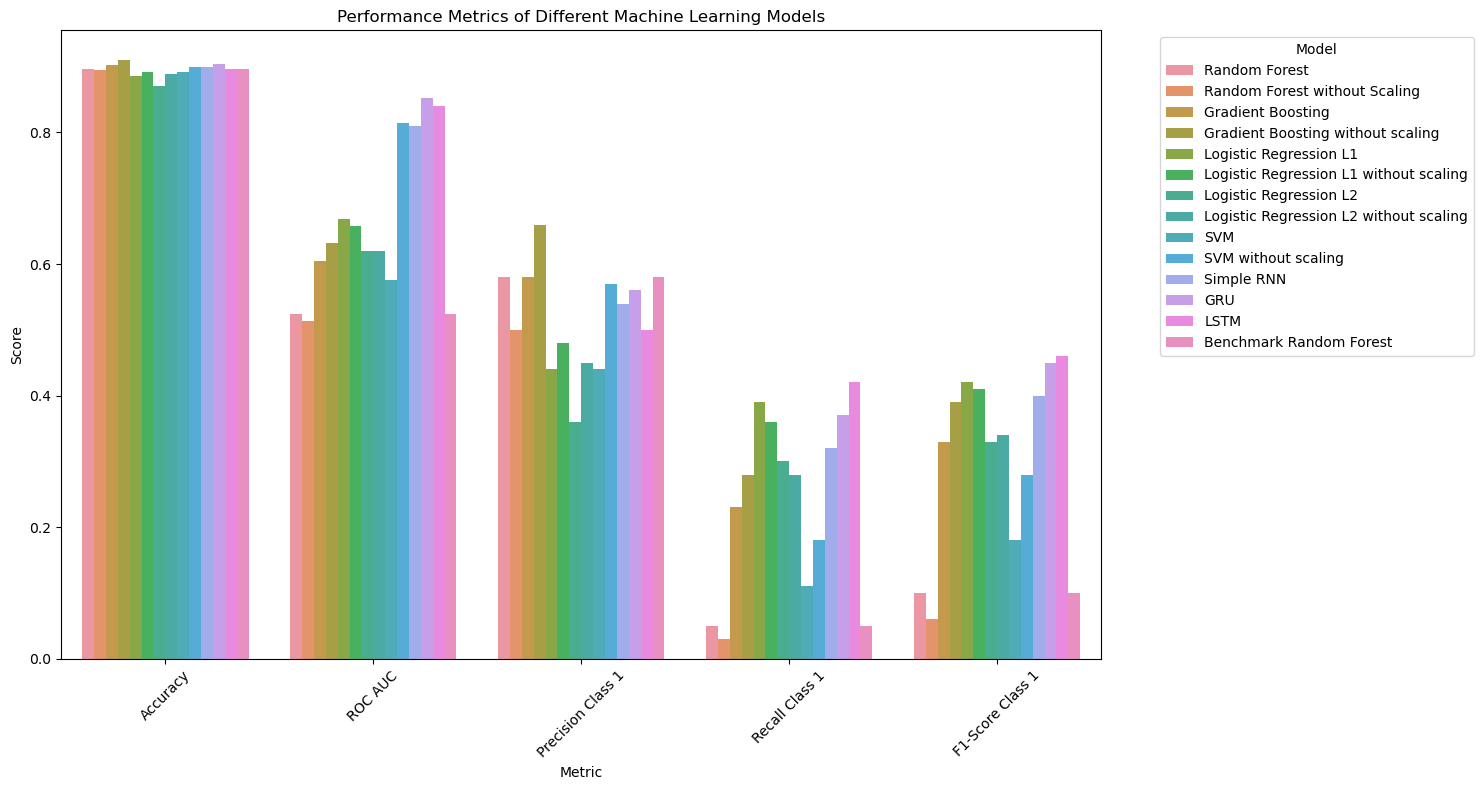

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for each model
data = {
    'Model': [
        'Random Forest', 'Random Forest without Scaling', 
        'Gradient Boosting', 'Gradient Boosting without scaling', 
        'Logistic Regression L1', 'Logistic Regression L1 without scaling', 
        'Logistic Regression L2', 'Logistic Regression L2 without scaling', 
        'SVM', 'SVM without scaling', 
        'Simple RNN', 'GRU', 'LSTM', 'Benchmark Random Forest'
    ],
    'Accuracy': [
        0.8972, 0.8956, 
        0.9019, 0.9098, 
        0.8853, 0.8916, 
        0.8710, 0.8884, 
        0.8924, 0.9003, 
        0.9003, 0.9035, 0.8964, 0.8972
    ],
    'ROC AUC': [
        0.5243, 0.5134, 
        0.6039, 0.6318, 
        0.6683, 0.6584, 
        0.6202, 0.6198, 
        0.5751, 0.8151, 
        0.8097, 0.8527, 0.8399, 0.5243
    ],
    'Precision Class 1': [
        0.58, 0.50, 
        0.58, 0.66, 
        0.44, 0.48, 
        0.36, 0.45, 
        0.44, 0.57, 
        0.54, 0.56, 0.50, 0.58  # Precision for class 1
    ],
    'Recall Class 1': [
        0.05, 0.03, 
        0.23, 0.28, 
        0.39, 0.36, 
        0.30, 0.28, 
        0.11, 0.18, 
        0.32, 0.37, 0.42, 0.05  # Recall for class 1
    ],
    'F1-Score Class 1': [
        0.10, 0.06, 
        0.33, 0.39, 
        0.42, 0.41, 
        0.33, 0.34, 
        0.18, 0.28, 
        0.40, 0.45, 0.46, 0.10  # F1-Score for class 1
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt DataFrame for seaborn plotting
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title('Performance Metrics of Different Machine Learning Models')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


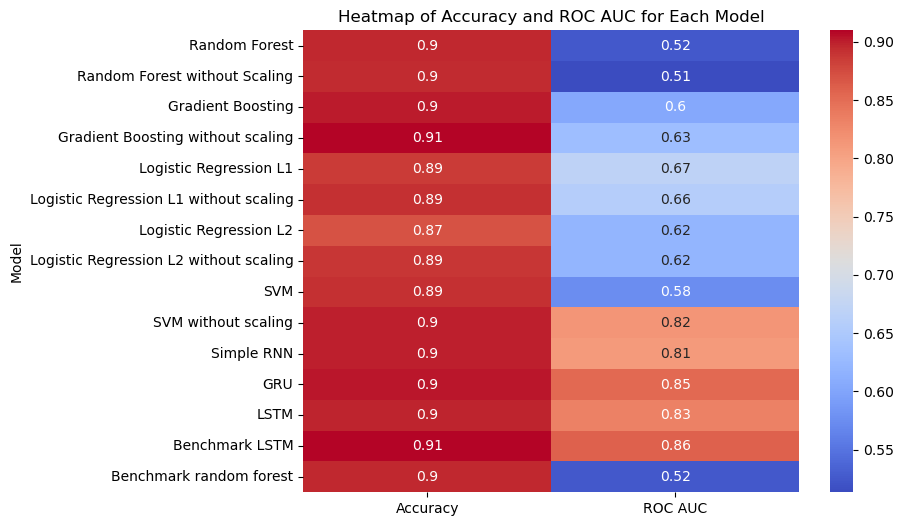

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Creating a smaller DataFrame for the heatmap
df_heatmap = df[['Model', 'Accuracy', 'ROC AUC']].set_index('Model')

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_heatmap, annot=True, cmap='coolwarm')
plt.title('Heatmap of Accuracy and ROC AUC for Each Model')
plt.show()


Now let's try to hyperparameter tune, the best performing model for this dataset as can be observed via the results is either GRU or LSTM depending on the statistical measures. For the purposes of this analysis, one of them was chosen at random, the GRU model, and was used for hyperparameter tuning purposes. Here is the code below.

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a function to create the RNN model
def create_rnn_model(gru_units, dropout_rate):
    model = Sequential()
    model.add(GRU(gru_units, return_sequences=False, input_shape=(48, 7403)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model so it can be used by scikit-learn
model = KerasClassifier(model=create_rnn_model, epochs=10, batch_size=64, verbose=0)

# Define the grid search parameters
param_grid = {
    'model__gru_units': [20, 50],
    'model__dropout_rate': [0.1, 0.2],
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(rnn_input_train, train_labels, validation_data=(rnn_input_val, val_labels))

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.891633 using {'model__dropout_rate': 0.1, 'model__gru_units': 50}


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Custom callback to compute ROC AUC, Precision, Recall, and F1 Score after each epoch
class MetricsCallback(Callback):
    def __init__(self, training_data, validation_data):
        self.x_train, self.y_train = training_data
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)

        # Convert predictions to binary (0 or 1)
        y_train_pred_bin = (y_train_pred > 0.5).astype(int)
        y_val_pred_bin = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        roc_auc_train = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
        precision_train = precision_score(self.y_train, y_train_pred_bin)
        precision_val = precision_score(self.y_val, y_val_pred_bin)
        recall_train = recall_score(self.y_train, y_train_pred_bin)
        recall_val = recall_score(self.y_val, y_val_pred_bin)
        f1_train = f1_score(self.y_train, y_train_pred_bin)
        f1_val = f1_score(self.y_val, y_val_pred_bin)

        print(f'Epoch {epoch+1}: roc_auc_train: {roc_auc_train}, roc_auc_val: {roc_auc_val}, '
              f'precision_train: {precision_train}, precision_val: {precision_val}, '
              f'recall_train: {recall_train}, recall_val: {recall_val}, '
              f'f1_train: {f1_train}, f1_val: {f1_val}')

# Define the RNN model with Dropout and GRU
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(48, 7403)))
model.add(Dropout(0.1)) 
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Initialize the metrics callback
metrics_callback = MetricsCallback(training_data=(rnn_input_train, train_labels),
                                   validation_data=(rnn_input_val, val_labels))

# Train the model with validation data and callbacks for early stopping and metrics
model.fit(rnn_input_train, train_labels, epochs=10, batch_size=64, 
          validation_data=(rnn_input_val, val_labels), callbacks=[metrics_callback, early_stopping])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(rnn_input_test, test_labels)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Calculate and print ROC AUC, Precision, Recall, and F1 Score for the test set
test_predictions = model.predict(rnn_input_test)
test_predictions_bin = (test_predictions > 0.5).astype(int)
roc_auc_test = roc_auc_score(test_labels, test_predictions)
precision_test = precision_score(test_labels, test_predictions_bin)
recall_test = recall_score(test_labels, test_predictions_bin)
f1_test = f1_score(test_labels, test_predictions_bin)

print(f"Test ROC AUC: {roc_auc_test}, Test Precision: {precision_test}, "
      f"Test Recall: {recall_test}, Test F1 Score: {f1_test}")


Epoch 1/10
40/40 [==============================] - 1s 22ms/step
Epoch 1: roc_auc_train: 0.6495113385510737, roc_auc_val: 0.8478652263374485, precision_train: 0.7857142857142857, precision_val: 0.46405228758169936, recall_train: 0.18940397350993377, recall_val: 0.4930555555555556, f1_train: 0.3052294557097118, f1_val: 0.4781144781144781
95/95 [==============================] - 26s 272ms/step - loss: 0.4349 - accuracy: 0.8756 - val_loss: 0.2956 - val_accuracy: 0.8787
Epoch 2/10
40/40 [==============================] - 1s 22ms/step
Epoch 2: roc_auc_train: 0.6928263596227172, roc_auc_val: 0.8470201352145796, precision_train: 0.9, precision_val: 0.48936170212765956, recall_train: 0.22649006622516557, recall_val: 0.4791666666666667, f1_train: 0.3619047619047619, f1_val: 0.4842105263157895
95/95 [==============================] - 28s 295ms/step - loss: 0.3272 - accuracy: 0.8913 - val_loss: 0.2969 - val_accuracy: 0.8850
Epoch 3/10
40/40 [==============================] - 1s 23ms/step
Epoch 3:

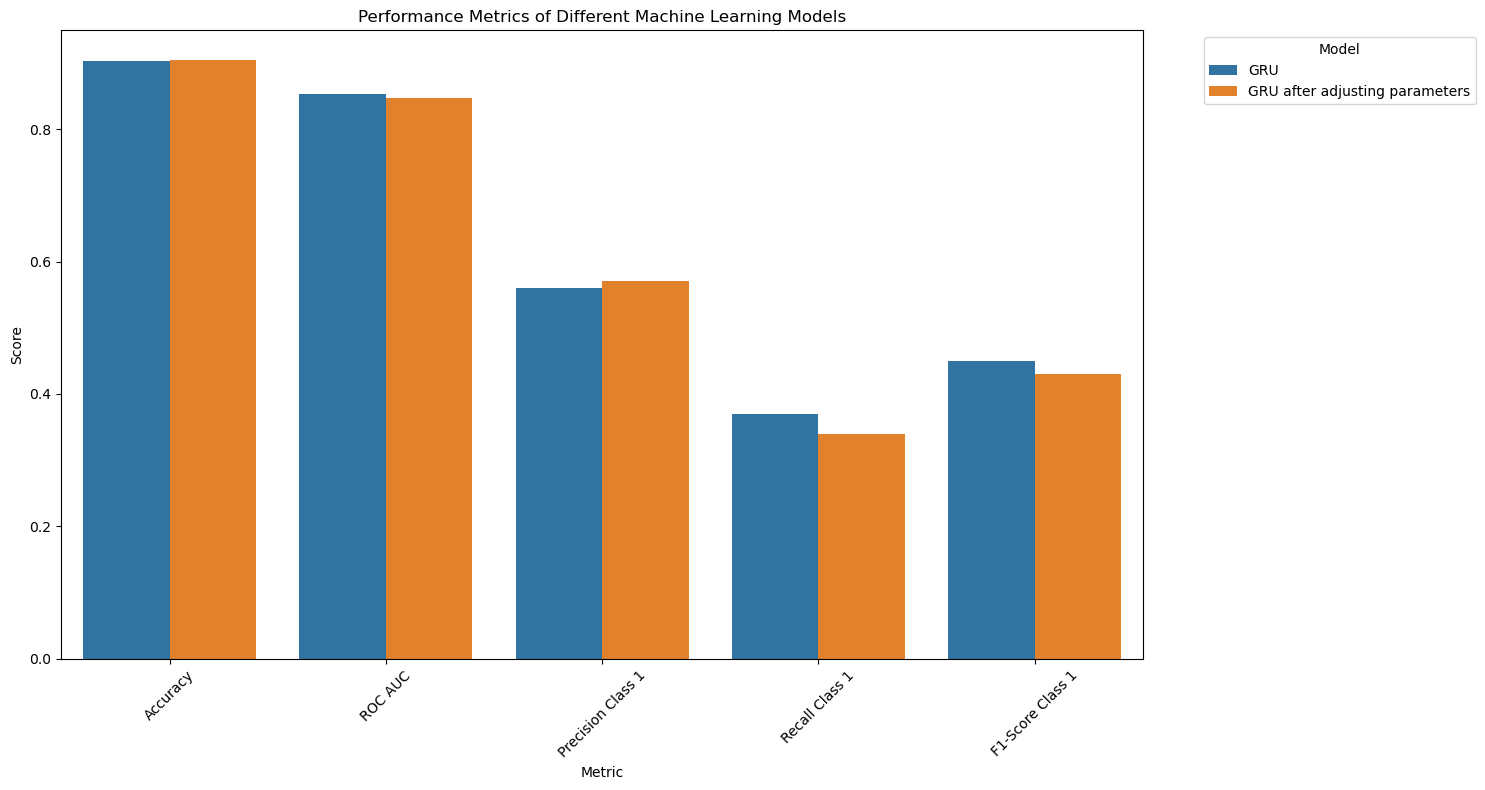

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for each model
data = {
    'Model': ['GRU', 'GRU after adjusting parameters'],
    'Accuracy': [0.9035, 0.9043],
    'ROC AUC': [0.8527, 0.8469],
    'Precision Class 1': [0.56, 0.57],   # Precision for class 1
    'Recall Class 1': [0.37, 0.34],   # Recall for class 1
    'F1-Score Class 1': [0.45, 0.43],   # F1-Score for class 1
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt DataFrame for seaborn plotting
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(15, 8))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted)
plt.title('Performance Metrics of Different Machine Learning Models')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


As once can see here, the model only improved in two categories (Accuracy & Precision) and regressed in three (ROC AUC, Recall, and F1-Score). This is common, as the hyperparameter tuning code done was not very exhaustive at all. Taking an exhaustive approach to hyper parameter tuning might improve overall results with the one negative that is higher computational expense and time. 